## Setup
This notebook was made on Python 3.11.5

In [1]:
%pip install numpy -q
%pip install pandas -q
%pip install scikit-learn -q
%pip install torch -q
%pip install transformers -q
%pip install gensim -q
%pip install -U sentence-transformers -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import numpy as np
import pickle
import torch

from collections import defaultdict
from torch.nn import CosineSimilarity

path_data = "Data/"

!bash downloads.bash $path_data

print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
Updated Git hooks.
Git LFS initialized.
The data were already unpacked
Cuda available: True


In [3]:
from data_processing import *

processed_path = "Processed/"
!mkdir Processed

directive_data_main = get_text_from_xml(path_data + "DIR_EN_32002L0044.xml", data_preprocessing)
provision_data_main = get_text_from_xml(path_data + "NIM_EN.xml", data_preprocessing)

directive_data_transformer = get_text_from_xml(path_data + "DIR_EN_32002L0044.xml", data_preprocessing_transformer)
provision_data_transformer = get_text_from_xml(path_data + "NIM_EN.xml", data_preprocessing_transformer)

labels = json.load(open("labels.json", "rb"))

mkdir: cannot create directory ‘Processed’: File exists


## Similarity scoring
* Cosine similarity $Cos(\textbf{D}_1, \textbf{D}_2)=\frac{\textbf{D}_1\cdot \textbf{D}_2}{\|\textbf{D}_1\|\cdot\|\textbf{D}_2\|}$ (where $\textbf{D}_1, \textbf{D}_1 \in \mathbb{R}^{1\times Dim}$)
* Euclidean distance $E(\textbf{D}_1, \textbf{D}_2)=\sqrt{\sum_{d=1}^{Dim}(x_{d}^{D_2}-x_{d}^{D_1})^2}$ or $\|D_1-D_2\|$ (where $\textbf{D}_1, \textbf{D}_1 \in \mathbb{R}^{1\times Dim}$)
* Jaccard scoring $J(D_1, D_2)=\frac{|D_1 \cap D_2|}{|D_1 \cup D_2}|$ (where $D_1, D_2$ are sets of words)

In [4]:
cos = CosineSimilarity(dim = 0)

def cosine_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    return cos(x, y)

def euclidean_distance(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    return torch.norm(torch.subtract(x, y))

def jaccard_score(x: set, y: set) -> float:
    return len(x & y)/len(x | y)

## Models

### Doc2vec

In [5]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

training_config = {
    'vector_size': 100,
    'epochs': 1000,
    'dm_tag_count': 3,
    'dm_mean': 1,
    'alpha': 0.015,
    'workers': 10,
    'min_count': 3
}

def encode_doc2vec(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    training_data = x_data["Text"].to_numpy()
    test_data = y_data["Text"].to_numpy()

    training_data = [TaggedDocument(text, [doc_id]) for doc_id, text in enumerate(training_data)]

    model_doc2vec = Doc2Vec(**training_config)
    model_doc2vec.build_vocab(training_data)
    model_doc2vec.train(training_data, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)

    x_data["Encoded_Text"] = [model_doc2vec.dv[idx] for idx in range(len(model_doc2vec.dv))]
    y_data["Encoded_Text"] = [model_doc2vec.infer_vector(test_sent) for test_sent in test_data]

    return x_data, y_data

### TFIDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(stop_words = None, lowercase = False, binary = True) # base bare bones tfidf no stop words

In [7]:
def encode_tfidf(x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    x_aux = [" ".join(text[:]) for text in x_data["Text"]]
    y_aux = [" ".join(text[:]) for text in y_data["Text"]]

    x_encoded = tfidf_model.fit_transform(x_aux)
    y_encoded = tfidf_model.transform(y_aux)

    x_data["Encoded_Text"] = list(x_encoded.toarray())
    y_data["Encoded_Text"] = list(y_encoded.toarray())

    return x_data, y_data

### Transformer embeddings - BERT (English, base, uncased)
use preprocessed text not original even though context matters bcs. there are MANY unique sub-words (e.g. 89/391/EEC)

In [8]:
from transformers import BertTokenizer, BertModel

model_name = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(model_name)
model_transformer = BertModel.from_pretrained(model_name).to(device)

In [9]:
from transformers import BatchEncoding

def encode_sentence_transformer(sentence: list) -> np.ndarray:
    sentence = " ".join(sentence)
    tokenized_sentence = tokenizer(sentence, max_length = 512, padding = "max_length", truncation = True, return_tensors = "pt", return_attention_mask = True)
    
    # cast all tensors to the same device -> speeds up prediction time and any subsequent computations
    aux = {}
    for key, value in tokenized_sentence.items():
        aux[key] = value.to(device)
    tokenized_sentence = BatchEncoding(aux)
    model_output = model_transformer(**tokenized_sentence)

    # pool the values of the last hidden state using a weighted averaged that ignores all tokens with 0 in the attention mask
    last_hidden_state = model_output.last_hidden_state[0]
    attention_mask = tokenized_sentence.attention_mask[0]
    attention_mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    data_attention = last_hidden_state * attention_mask
    sentence_vector = torch.sum(data_attention, 0)/torch.clamp(attention_mask.sum(0), min = 1e-9)

    return np.array(sentence_vector.cpu().detach().numpy())

def encode_transformer(data: pd.DataFrame) -> pd.DataFrame:
    data["Encoded_Text"] = data["Text"].apply(encode_sentence_transformer)

    return data


### Sentence Transformer

In [10]:
from sentence_transformers import SentenceTransformer

model_sentence = SentenceTransformer("all-distilroberta-v1").to(device)

In [11]:
def encode_sentence_stransformer(sentence: list) -> torch.Tensor:
    return model_sentence.encode(" ".join(sentence))

def encode_stransformer(data: pd.DataFrame) -> pd.DataFrame:
    data["Encoded_Text"] = data["Text"].apply(encode_sentence_stransformer)

    return data

## Evaluation metrics
* $P = \frac{TP}{TP+FP}$
* $R = \frac{TP}{TP+FN}$
* $F1 = \frac{2\cdot P\cdot R}{P+R}$

In [12]:
def compute_similarity(directive_data: pd.DataFrame, provision_data: pd.DataFrame, similarity_function: callable = cos, threshold: float|int = 1, top_n: int = 3) -> list:
    if similarity_function == jaccard_score:
        dir_matrix = directive_data.copy()["Text"].apply(lambda x: set(x)).to_numpy()
        pro_matrix = provision_data.copy()["Text"].apply(lambda x: set(x)).to_numpy()

    else:
        dir_matrix = torch.from_numpy(np.asarray(directive_data["Encoded_Text"].tolist(), dtype=float))
        pro_matrix = torch.from_numpy(np.asarray(provision_data["Encoded_Text"].tolist(), dtype=float))

    labels_pred = defaultdict()
    for id, d1 in zip(directive_data["ID"], dir_matrix):
        scores = []
        for d2 in pro_matrix:
            score = similarity_function(d1, d2)
            scores.append(score.item() if torch.is_tensor(score) else score)

        scores = np.asarray(scores)

        if similarity_function != cosine_similarity and similarity_function != jaccard_score:
            threshold_check = lambda x: x >= threshold
            best_idx = np.argsort(scores)[::][:top_n]
        else:
            threshold_check = lambda x: x < threshold
            best_idx = np.argsort(scores)[::-1][:top_n]

        idx = 0
        aux = []
        while idx < len(best_idx):
            if threshold_check(scores[best_idx[idx]]):
                break
            aux.append(best_idx[idx])
            idx += 1

        best_idx = aux
        label = provision_data.iloc[best_idx]["ID"].to_list() if len(best_idx) > 0 else ["Null"]
        labels_pred[id] = label

    return labels_pred

In [13]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# convert the labels from string IDs to binary representations for multi-label classification
def binarize_labels(input_labels: list, true_labels: list) -> list:
    true_labels = [label for labels in true_labels for label in labels]
    true_labels.sort()
    true_labels = sorted(set(true_labels), key=true_labels.index)

    binary_labels = []
    for input_ids in input_labels:
        binary_ids = []
        for id in true_labels:
            binary_ids.append(int(id in input_ids))

        binary_labels.append(binary_ids)

    return np.asarray(binary_labels)

def evaluation(predicted_labels: defaultdict, true_labels: defaultdict) -> (dict, np.ndarray):
    true_binary = binarize_labels(list(true_labels.values()), list(true_labels.values()))
    predicted_binary = binarize_labels(list(predicted_labels.values()), list(true_labels.values()))

    results = classification_report(true_binary, predicted_binary, output_dict = True, zero_division = 0) # precision + recall + f1 
    confusion_matrix = multilabel_confusion_matrix(true_binary, predicted_binary)

    return results, confusion_matrix

## Evaluation of models

In [14]:
# wrapper function for data encoding
def encode(encoding_method: callable, x_data: pd.DataFrame, y_data: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    if encoding_method in (encode_tfidf, encode_doc2vec):
        x_data, y_data = encoding_method(x_data, y_data)
    else:
        x_data = encoding_method(x_data)
        y_data = encoding_method(y_data)

    return x_data, y_data

# wrapper function for prediction
def predict(x_data: pd.DataFrame, y_data: pd.DataFrame, **kwargs) -> defaultdict:
    return compute_similarity(x_data, y_data, kwargs["similarity_function"], kwargs["threshold"], kwargs["top_n"])


In [15]:
evaluation_pairs = {
    "Jaccard Scoring": (None, {"jaccard": 0.21}),
    "TF-IDF": (encode_tfidf, {"cosine": 0.2, "euclidean": 1.1}),
    "Transformer": (encode_transformer, {"cosine": 0.89, "euclidean": 2.6}),
    "Sentence Transformer": (encode_stransformer, {"cosine": 0.7, "euclidean": 0.9}),
    "Doc2vec": (encode_doc2vec, {"cosine": 0.46, "euclidean": 14})
}

similarity_functions = {"cosine": cosine_similarity, "euclidean": euclidean_distance, "jaccard": jaccard_score}
scores = defaultdict(dict)
for method, (encoding_method, thresholds) in evaluation_pairs.items():
    print(method)
    directive_data, provision_data = (directive_data_transformer, provision_data_transformer) \
        if encoding_method == encode_stransformer else (directive_data_main, provision_data_main)
    
    if encoding_method != None:
        directive_data, provision_data = encode(encoding_method = encoding_method, x_data = directive_data, y_data = provision_data)

    for similarity_name, similarity_function in similarity_functions.items():
        if similarity_name not in thresholds.keys():
            continue

        predicted_labels = predict(directive_data, provision_data, similarity_function = similarity_function, threshold = thresholds[similarity_name], top_n = 3)
        metrics = evaluation(predicted_labels, labels)

        scores[method][similarity_name] = metrics

Jaccard Scoring
TF-IDF
Transformer
Sentence Transformer
Doc2vec


## Visualisation of results

In [16]:
avg_methods = ["micro avg", "macro avg", "samples avg", "weighted avg"]

all_scores = []
similarity_functions = ["jaccard", "cosine", "euclidean"]

for encoding in evaluation_pairs.keys():
    if encoding == "Jaccard Scoring":
        similarity = similarity_functions[:1]
    else:
        similarity = similarity_functions[1:]
    
    for sim in similarity:
        score_dictionary = {"Encoding": [encoding.replace(" ", "\n")] * 4 * 3, "Similarity": [sim] * 4 * 3, "AVG": [], "Metric": [], "Score": []}
        metrics = scores[encoding][sim][0] # choose classification report
        for avg in avg_methods:
            keys = list(metrics[avg].keys())[:-1]
            s = [round(metrics[avg][m],3) for m in keys]
            score_dictionary["AVG"] += [avg] * 3
            for k, si in zip(keys, s):
                score_dictionary["Metric"] += [k]
                score_dictionary["Score"] += [si]

        score_df = pd.DataFrame(score_dictionary)
        all_scores.append(score_df)

all_scores = pd.concat(all_scores)
all_scores

,Encoding,Similarity,AVG,Metric,Score
0,Jaccard\nScoring,jaccard,micro avg,precision,0.738
1,Jaccard\nScoring,jaccard,micro avg,recall,0.816
2,Jaccard\nScoring,jaccard,micro avg,f1-score,0.775
3,Jaccard\nScoring,jaccard,macro avg,precision,0.660
4,Jaccard\nScoring,jaccard,macro avg,recall,0.796
...,...,...,...,...,...
7,Doc2vec,euclidean,samples avg,recall,0.468
8,Doc2vec,euclidean,samples avg,f1-score,0.311
9,Doc2vec,euclidean,weighted avg,precision,0.490
10,Doc2vec,euclidean,weighted avg,recall,0.447


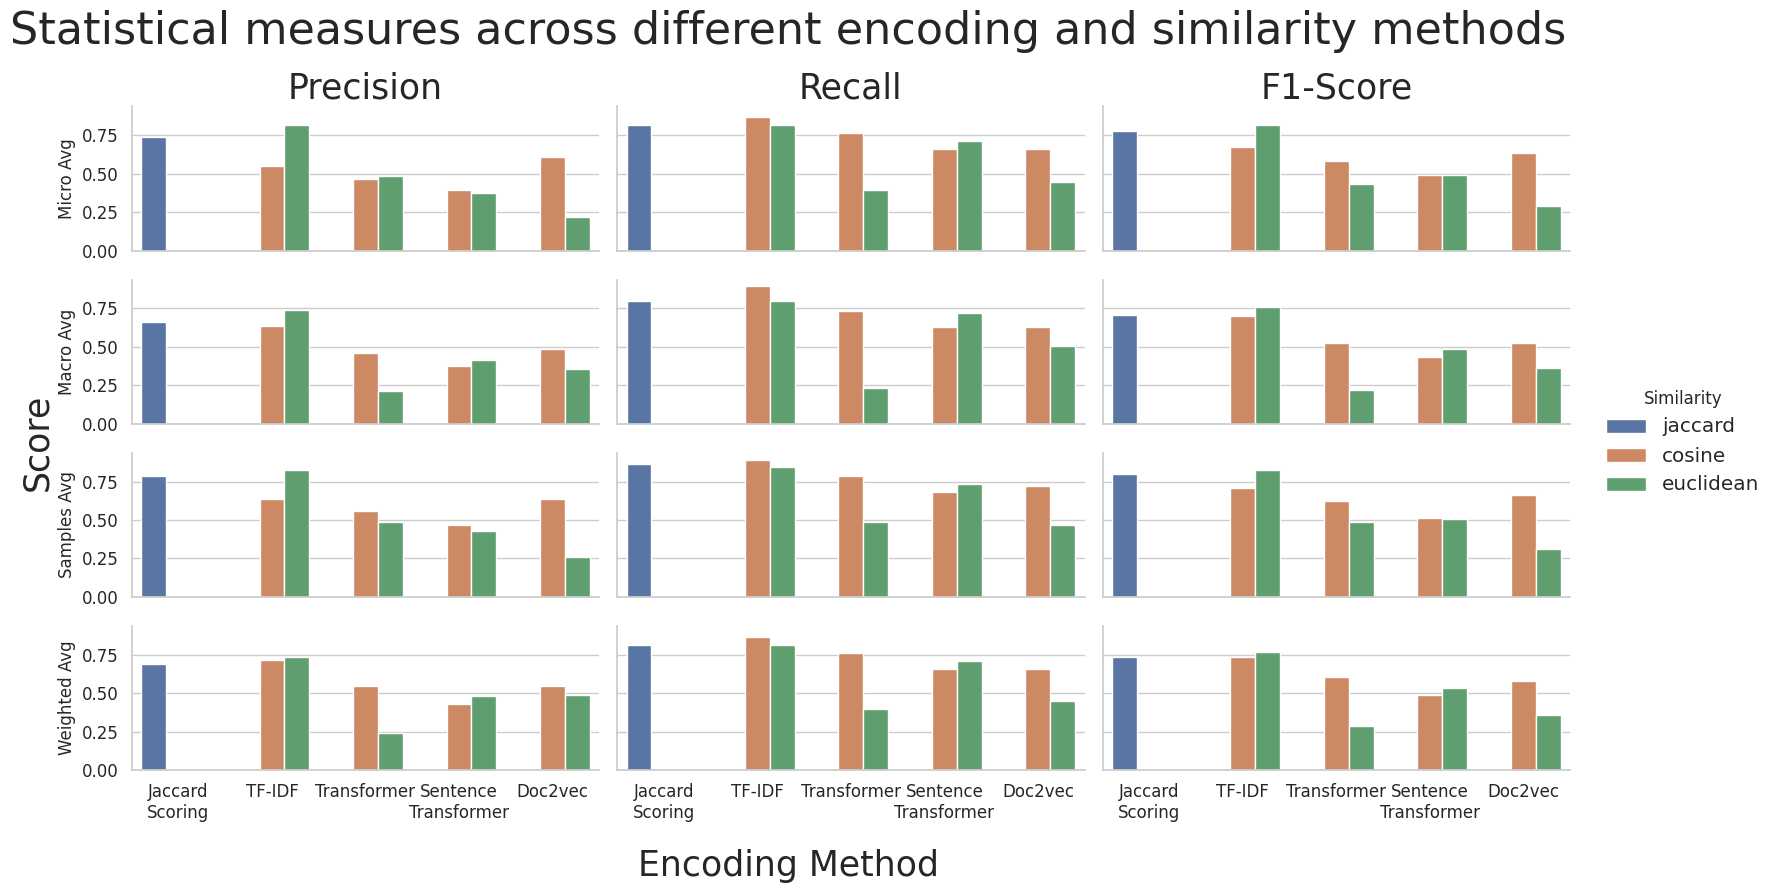

In [17]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

fig, axes = plt.subplots(4, 3, figsize=(16,9), sharex=True, sharey=True)
axes = axes.T
metric_order = ["precision", "recall", "f1-score"]

legend_not_set = True
labels_plot = ""
plot = ""
for ax_column, metric in zip(axes, metric_order):
    metric_set = False
    for ax, avg in zip(ax_column, avg_methods):
        aux_data = all_scores[(all_scores["AVG"] == avg) & (all_scores["Metric"] == metric)]
        plot = sns.barplot(data=aux_data, x="Encoding", y="Score", hue="Similarity", ax=ax, legend=True)
        ax.legend().remove()
        legend_not_set = False
        ax.set_title(metric.title(), fontsize=25) if not metric_set else 1
        metric_set = True
        ax.set_xlabel("")
        ax.set_ylabel(avg.title()) if metric == "precision" else 1
        ax.tick_params(labelsize=12)

fig.suptitle("Statistical measures across different encoding and similarity methods", fontsize=32)
fig.supxlabel("Encoding Method", fontsize=25)
fig.supylabel("Score", fontsize=25)
plt.tight_layout()
handles, labels_legend = ax.get_legend_handles_labels()
plt.figlegend(handles, labels_legend, loc='center left', bbox_to_anchor=(1, 0.5), title="Similarity", fontsize="large", frameon=False)
sns.despine()

plt.show()

In [18]:
scores["Doc2vec"]["euclidean"][1]

unique_labels = labels

unique_labels = list(unique_labels.values())
unique_labels = [label for ls in unique_labels for label in ls]
unique_labels
unique_labels.sort()
unique_labels = sorted(set(unique_labels), key=unique_labels.index)

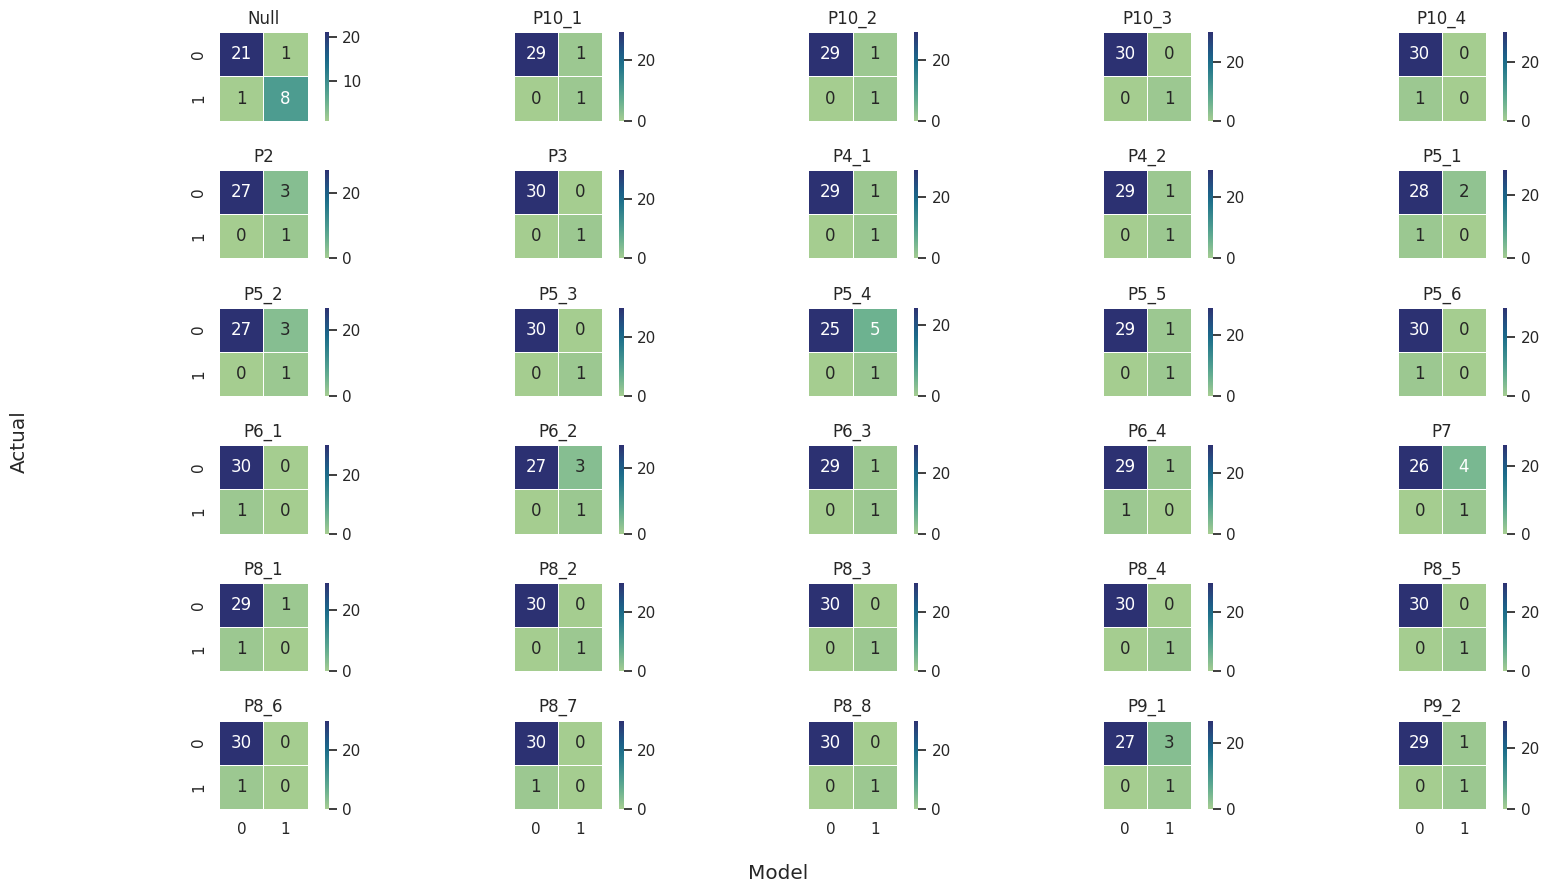

In [19]:
sns.set_theme(context="notebook")

fig, axes = plt.subplots(6, 5, figsize=(16,9), sharex=True, sharey=True)
axes = axes.reshape(-1)

for ax, label, matrix in zip(axes, unique_labels, scores["Transformer"]["cosine"][1]):
    sns.heatmap(matrix, ax = ax, annot=True, square=True, linewidth=0.5, cmap="crest")
    ax.set_title(label)

fig.supxlabel("Model")
fig.supylabel("Actual")
plt.tight_layout()
plt.show()

## Other

In [20]:
import itertools
from tqdm import tqdm

def encode_doc2vec_search(x_data: pd.DataFrame, y_data: pd.DataFrame, config) -> (pd.DataFrame, pd.DataFrame):
    training_data = x_data["Text"].to_numpy()
    test_data = y_data["Text"].to_numpy()

    training_data = [TaggedDocument(text, [doc_id]) for doc_id, text in enumerate(training_data)]

    model_doc2vec = Doc2Vec(**config)
    model_doc2vec.build_vocab(training_data)
    model_doc2vec.train(training_data, total_examples = model_doc2vec.corpus_count, epochs = model_doc2vec.epochs)

    x_data["Encoded_Text"] = [model_doc2vec.dv[idx] for idx in range(len(model_doc2vec.dv))]
    y_data["Encoded_Text"] = [model_doc2vec.infer_vector(test_sent) for test_sent in test_data]

    return x_data, y_data

def grid_search_doc2vec():
    thresholds = {"cosine": 0.46, "euclidean": 15}

    search = {
        "vector_size": [100, 256, 512, 768],
        "epochs": [100, 200, 400, 800, 1000],
        "dm_tag_count": [3],
        "dm_mean": [1],
        "alpha": [0.01, 0.015, 0.02, 0.025],
        "workers": [10],
        "min_count": [3, 5, 7]
    }

    keys, values = zip(*search.items())
    a = {"Model": [], "F1": [], "Config": []}
    for idx, v in tqdm(enumerate(itertools.product(*values))):
        training_config = dict(zip(keys, v))

        similarity_functions = {"cosine": cosine_similarity}
        directive_data, provision_data = directive_data_main, provision_data_main
        directive_data, provision_data = encode_doc2vec_search(x_data = directive_data, y_data = provision_data, config = training_config)

        for similarity_name, similarity_function in similarity_functions.items():
            predicted_labels = predict(directive_data, provision_data, similarity_function = similarity_function, threshold = thresholds[similarity_name], top_n = 3)
            metrics = evaluation(predicted_labels, labels)

            # scores[method + str(idx)][similarity_name] = metrics[0]["micro avg"]["f1-score"]
            a["Model"] += [method + str(idx)]
            a["F1"] += [metrics[0]["micro avg"]["f1-score"]]
            a["Config"] += [training_config]

    return a

In [21]:
# a = grid_search_doc2vec()

In [22]:
# a = pd.DataFrame(a)
# a["F1"].max()
# a[a["F1"] == a["F1"].max()]["Config"].item()